# Working with Data: `Dataset`, `DataLoader`, `Sampler`, and `Transforms`

These basic concepts make it easy to work with large data.

## Init, helpers, utils, ...

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace

# Dataset
It's easy to create your `Dataset`,
but PyTorch comes with some
[build-in datasets](https://pytorch.org/docs/stable/torchvision/datasets.html):

- MNIST
- Fashion-MNIST
- KMNIST
- EMNIST
- FakeData
- COCO
  - Captions
  - Detection
- LSUN
- ImageFolder
- DatasetFolder
- Imagenet-12
- CIFAR
- STL10
- SVHN
- PhotoTour
- SBU
- Flickr
- VOC
- Cityscapes

`Dataset` gives you information about the number of samples (implement `__len__`) and gives you the sample at a given index (implement `__getitem__`.
It's a nice and simple abstraction to work with data.

In [4]:
from torch.utils.data import Dataset

```python
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```

The `ImageFolder` dataset is quite useful and follows the usual conventions for folder layouts:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

## Example

In [5]:
# %load my_datasets.py
import os
import zipfile

from torchvision.datasets.folder import ImageFolder, default_loader
from torchvision.datasets.utils import download_url, check_integrity


################################################################################
# PyTorch
class DogsCatsDataset(ImageFolder):
    """
    The 'Dogs and Cats' dataset from kaggle.

    https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/

    Args:
        root: the location where to store the dataset
        suffix: path to the train/valid/sample dataset. See folder structure.
        transform (callable, optional): A function/transform that takes in
            an PIL image and returns a transformed version.
            E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that
            takes in the target and transforms it.
        loader: A function to load an image given its path.
        download: if ``True``, download the data.


    The folder structure of the dataset is as follows::

        └── dogscats
            ├── sample
            │   ├── train
            │   │   ├── cats
            │   │   └── dogs
            │   └── valid
            │       ├── cats
            │       └── dogs
            ├── train
            │   ├── cats
            │   └── dogs
            └── valid
                ├── cats
                └── dogs

    """

    url = "http://files.fast.ai/data/dogscats.zip"
    filename = "dogscats.zip"
    checksum = "aef22ec7d472dd60e8ee79eecc19f131"

    def __init__(
        self,
        root: str,
        suffix: str,
        transform=None,
        target_transform=None,
        loader=default_loader,
        download=False,
    ):
        self.root = os.path.expanduser(root)

        if download:
            self._download()
            self._extract()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted. "
                "You can use download=True to download it"
            )

        path = os.path.join(self.root, "dogscats", suffix)
        print(f"Loading data from {path}.")
        assert os.path.isdir(path), f"'{suffix}' is not valid."

        super().__init__(path, transform, target_transform, loader)

    def _download(self):
        if self._check_integrity():
            print("Dataset already downloaded and verified.")
            return

        root = self.root
        print("Downloading dataset... (this might take a while)")
        download_url(self.url, root, self.filename, self.checksum)

    def _extract(self):
        path_to_zip = os.path.join(self.root, self.filename)
        with zipfile.ZipFile(path_to_zip, "r") as zip_ref:
            zip_ref.extractall(self.root)

    def _check_integrity(self):
        path_to_zip = os.path.join(self.root, self.filename)
        return check_integrity(path_to_zip, self.checksum)


In [6]:
train_ds = DogsCatsDataset("../data/raw", "sample/train")

Loading data from ../data/raw/dogscats/sample/train.


In [7]:
!tree -d ../data/raw/dogscats/

../data/raw/dogscats/
├── models
├── sample
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── valid
│       ├── cats
│       └── dogs
├── test1
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

15 directories


In [8]:
train_ds

Dataset DogsCatsDataset
    Number of datapoints: 16
    Root location: ../data/raw/dogscats/sample/train

In [9]:
# the __len__ method
len(train_ds)

16

In [10]:
# the __getitem__ method
train_ds[0]

(<PIL.Image.Image image mode=RGB size=499x375 at 0x7F1E288AC400>, 0)

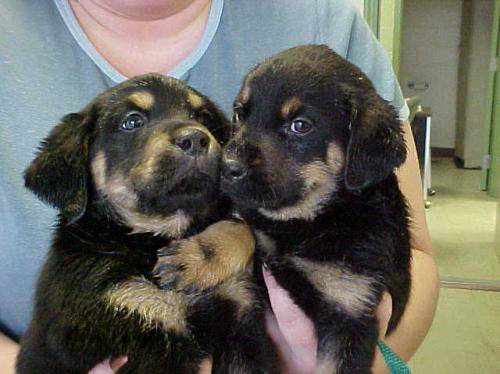

In [11]:
train_ds[14][0]

In [12]:
train_ds[14][1]

1

Optionally, some datasets offer convenience functions and attributes.
This is not enforced by the interface! Don't rely on it!

In [13]:
train_ds.classes

['cats', 'dogs']

In [14]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [15]:
train_ds.imgs

[('../data/raw/dogscats/sample/train/cats/cat.11737.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.2266.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.2921.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.3570.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.394.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.4600.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.4865.jpg', 0),
 ('../data/raw/dogscats/sample/train/cats/cat.9021.jpg', 0),
 ('../data/raw/dogscats/sample/train/dogs/dog.1402.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.1614.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.2423.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.6391.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.6768.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.8091.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.8643.jpg', 1),
 ('../data/raw/dogscats/sample/train/dogs/dog.9077.jpg', 1)]

In [16]:
import random

1 dogs


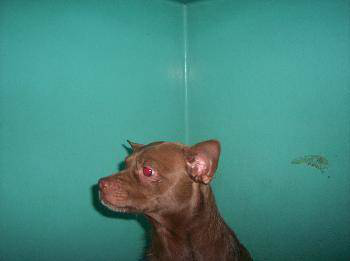

1 dogs


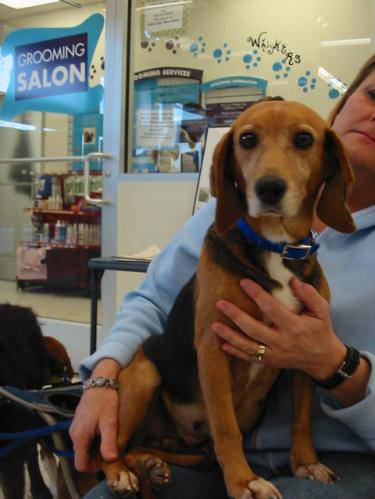

1 dogs


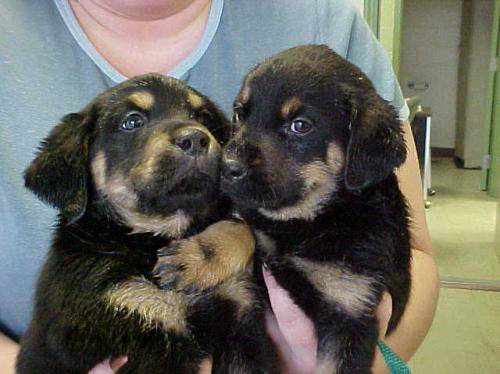

0 cats


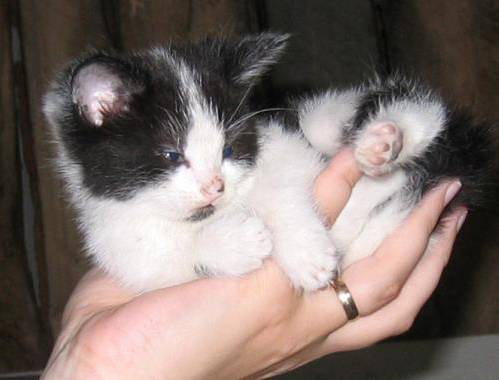

In [17]:
for img, label_id in random.sample(list(train_ds), 4):
    print(label_id, train_ds.classes[label_id])
    display(img)

# `torchvision.transforms`

Common image transformation that can be composed/chained [[docs]](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [18]:
from torchvision import transforms

In [19]:
_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


trans = transforms.Compose([
    transforms.RandomCrop(_image_size),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

trans(train_ds[13][0])

tensor([[[-1.2959, -1.2788, -1.2788,  ...,  2.2489,  2.2489,  2.2489],
         [-1.3473, -1.3130, -1.3130,  ...,  2.2489,  2.2489,  2.2489],
         [-1.3987, -1.3815, -1.3644,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-1.5185, -1.7754, -1.4843,  ..., -0.6452, -0.6109, -0.3712],
         [-1.5357, -1.7583, -1.5357,  ..., -0.6965, -0.7650, -0.5424],
         [-1.5528, -1.7240, -1.5014,  ..., -1.1589, -1.1247, -0.9020]],

        [[-1.3529, -1.3354, -1.3354,  ...,  2.4286,  2.4286,  2.4286],
         [-1.3704, -1.3704, -1.3704,  ...,  2.4286,  2.4286,  2.4286],
         [-1.4230, -1.4055, -1.3880,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-1.4230, -1.7031, -1.4755,  ..., -0.4601, -0.4251, -0.1625],
         [-1.4405, -1.6856, -1.5280,  ..., -0.5126, -0.5826, -0.3550],
         [-1.4580, -1.6506, -1.5455,  ..., -0.9328, -0.8978, -0.6702]],

        [[-1.2467, -1.2641, -1.2641,  ...,  2.6400,  2.6400,  2.6400],
         [-1.2816, -1.2641, -1.2990,  ...,  2

## `torchvision.transforms.functional`

>Functional transforms give you fine-grained control of the transformation pipeline. As opposed to the transformations above, functional transforms don’t contain a random number generator for their parameters. That means you have to specify/generate all parameters, but you can reuse the functional transform. For example, you can apply a functional transform to multiple images like this:
>
> https://pytorch.org/docs/stable/torchvision/transforms.html#functional-transforms

```python
import torchvision.transforms.functional as TF
import random

def my_segmentation_transforms(image, segmentation):
    if random.random() > 5:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle)
    # more transforms ...
    return image, segmentation
```

Ref:
- https://pytorch.org/docs/stable/torchvision/transforms.htm
- https://pytorch.org/docs/stable/torchvision/transforms.html#functional-transforms
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://github.com/mdbloice/Augmentor
- https://github.com/aleju/imgaug

Shout-out:
- Hig performance image augmentation with pillow-simd [[github]](https://github.com/uploadcare/pillow-simd) [[benchmark]](http://python-pillow.org/pillow-perf/)
- Improving Deep Learning Performance with AutoAugment [[blog]](https://ai.googleblog.com/2018/06/improving-deep-learning-performance.html) [[paper]](https://arxiv.org/abs/1805.09501) [[pytorch implementation]](https://github.com/DeepVoltaire/AutoAugment)

# Dataloader
The `DataLoader` class offers batch loading of datasets with multi-processing and different sample strategies [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

The signature looks something like this:
```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=default_collate,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None
)
```

In [20]:
from torch.utils.data import DataLoader

In [21]:
train_ds = DogsCatsDataset("../data/raw", "sample/train", transform=trans)
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

Loading data from ../data/raw/dogscats/sample/train.


In [22]:
train_iter = iter(train_dl)
X, y = next(train_iter)

In [23]:
print("X:", X.shape)
print("y:", y.shape)

X: torch.Size([2, 3, 224, 224])
y: torch.Size([2])


Note that I passed `trans`, which returns `torch.Tensor`, not pillow images.
DataLoader expects tensors, numbers, dicts or lists.

In [24]:
_train_ds = DogsCatsDataset("../data/raw", "sample/train", transform=None) 
_train_dl = DataLoader(_train_ds, batch_size=2, shuffle=True)

try:
    for batch in _train_dl:
        pass
except TypeError as e:
    print("ERROR")
    print(e)

Loading data from ../data/raw/dogscats/sample/train.
ERROR
default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


## `collate_fn`
The `collate_fn` argument of `DataLoader` allows you to customize how single datapoints are put together into a batch.
`collate_fn` is a simple callable that gets a list of datapoints (i.e. what `dataset.__getitem__` returns).

Example of a custom `collate_fn`
(taken from [here](https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3)):

In [25]:
def my_collate_fn(list_of_x_y):
    data = [item[0] for item in list_of_x_y]
    target = [item[1] for item in list_of_x_y]
    target = torch.LongTensor(target)
    return [data, target]

# Sampler
`Sampler` define **how** to sample from the dataset [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.sampler.Sampler).

Examples:
- `SequentialSampler`
- `RandomSamples`
- `SubsetSampler`
- `WeightedRandomSampler`

Write your own by simply implementing `__iter__` to iterate over the indices of the dataset.

```python
class Sampler(object):
    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
```

# Recap
- `Dataset`: get one datapoint
- `transforms`: composable transformations
- `DataLoader`: combine single datapoints into batches (plus multi processing and more)
- `Sampler`: **how** to sample from a dataset

**Simple but extensible interfaces**

# Exercise
Go out and play:

- Maybe extend the `DogsCatsDataset` such that you can specify the size of dataset, i.e. the number of samples.
- Maybe try the `Subset` [[docs]](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) to create smaller datasets.
- Maybe create `SubsetFraction` where you can specify the size of the dataset (between 0. and 1.).
- Maybe write a custom collate function for the `DogsCatsDataset` that turns it into a dataset appropriate to use in an autoencoder settings.

In [26]:
def autoencoder_collate_fn(list_of_x_y):
    # TODO implement me
    pass

In [27]:
class MyDataSet(Dataset):
    def __init__(self):
        super().__init__()
        # TODO implement me
    
    def __len__(self):
        # TODO implement me
        pass
    
    def __getitem__(self, idx):
        # TODO implement me
        pass